/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_88']
Received: inputs=Tensor(shape=(1, 512, 512, 3))
  warnings.warn(msg)


Step 0
Step 50
Step 100
Step 150
Step 200
Step 250


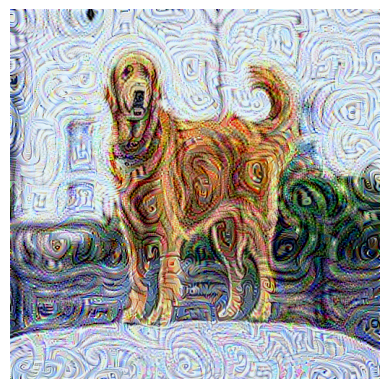

In [5]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load and preprocess image
def load_img(path):
    img = Image.open(path).convert('RGB').resize((512, 512))  # Ensure 3 channels (RGB)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.expand_dims(img, 0)
    return tf.keras.applications.vgg19.preprocess_input(img)


# Deprocess image to view it
def deprocess(img):
    x = img[0].copy()
    x = x[:, :, ::-1]  # BGR to RGB
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    return np.clip(x, 0, 255).astype(np.uint8)

# Define model to extract style and content
def get_model():
    layers = ['block5_conv2', 'block1_conv1']
    outputs = [vgg.get_layer(name).output for name in layers]
    return tf.keras.Model([vgg.input], outputs)

# Gram matrix for style
def gram_matrix(tensor):
    x = tf.squeeze(tensor)
    x = tf.reshape(x, [-1, x.shape[-1]])
    return tf.matmul(x, x, transpose_a=True)

# Load model
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False
model = get_model()

# Load images
content = load_img("/content/dog.jpg")
style = load_img("/content/style.jpg")
generated = tf.Variable(content, dtype=tf.float32)

# Extract features
style_target, content_target = model([style])
optimizer = tf.optimizers.Adam(5.0)

# Training step
@tf.function
def train_step():
    with tf.GradientTape() as tape:
        s_feat, c_feat = model(generated)
        s_loss = tf.reduce_mean((gram_matrix(s_feat) - gram_matrix(style_target)) ** 2)
        c_loss = tf.reduce_mean((c_feat - content_target) ** 2)
        loss = s_loss * 1e-2 + c_loss
    grads = tape.gradient(loss, generated)
    optimizer.apply_gradients([(grads, generated)])
    generated.assign(tf.clip_by_value(generated, -128, 128))

# Run style transfer
for i in range(300):
    train_step()
    if i % 50 == 0:
        print(f"Step {i}")

# Show result
plt.imshow(deprocess(generated.numpy()))
plt.axis('off')
plt.show()